# 编写自定义数据集，数据加载器和转换

> 原文： [https://pytorch.org/tutorials/beginner/data\_loading\_tutorial.html](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

注意

单击此处的[下载完整的示例代码](https://pytorch.apachecn.org/docs/_downloads/21adbaecd47a412f8143afb1c48f05a6/data_loading_tutorial.ipynb#sphx-glr-download-beginner-data-loading-tutorial-py)

**作者**： [Sasank Chilamkurthy](https://chsasank.github.io/)

解决任何机器学习问题都需要花费大量精力来准备数据。 PyTorch 提供了许多工具来简化数据加载过程，并有望使代码更具可读性。 在本教程中，我们将了解如何从非空的数据集中加载和预处理/增强数据。

要运行本教程，请确保已安装以下软件包：

- `scikit-image`：用于图像 io 和变换
- `pandas`：用于更轻松的 csv 解析

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

我们要处理的数据集是面部姿势数据集。 这意味着将对面部进行如下注释：

[![../_images/landmarked_face2.png](img/a9d4cfeae43b1acb77f9175122955f26.jpg)](https://pytorch.apachecn.org/docs/_images/landmarked_face2.png)

总体上，每个面孔都标注了 68 个不同的界标点。

Note

从[此处](https://download.pytorch.org/tutorial/faces.zip)下载数据集，将图像存放于名为“ data / faces /”的目录中。 该数据集实际上是通过对来自标记为“面部”的 imagenet 上的一些图像应用出色的 [dlib 姿态估计](https://blog.dlib.net/2014/08/real-time-face-pose-estimation.html)生成的。

数据集带有一个带注释的 csv 文件，如下所示：

让我们快速阅读 CSV 并获取(N，2）数组中的注释，其中 N 是地标数。

In [2]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


让我们编写一个简单的辅助函数来显示图像及其地标，并使用它来显示示例。

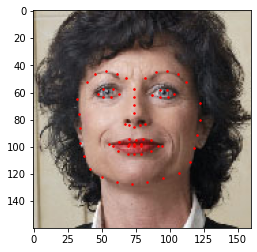

In [3]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
               landmarks)
plt.show()

## 数据集类

`torch.utils.data.Dataset`是代表数据集的抽象类。 您的自定义数据集应继承`Dataset`并覆盖以下方法：

- `__len__`，以便`len(dataset)`返回数据集的大小。
- `__getitem__`支持索引，以便可以使用`dataset[i]`获取第![](img/31df9c730e19ca29b59dce64b99d98c1.jpg)个样本

让我们为面部轮廓数据集创建一个数据集类。 我们将在`__init__`中读取 csv，但将图像读取留给`__getitem__`。 由于所有图像不会立即存储在内存中，而是根据需要读取，因此可以提高存储效率。

我们的数据集样本将是 dict `{'image': image, 'landmarks': landmarks}`。 我们的数据集将使用可选参数`transform`，以便可以将任何所需的处理应用于样本。 我们将在下一部分中看到`transform`的有用性。

In [4]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

让我们实例化该类并遍历数据样本。 我们将打印前 4 个样本的大小并显示其地标。

0 (324, 215, 3) (68, 2)


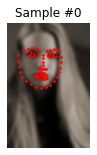

1 (500, 333, 3) (68, 2)


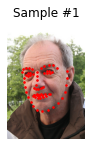

2 (250, 258, 3) (68, 2)


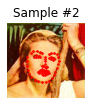

3 (434, 290, 3) (68, 2)


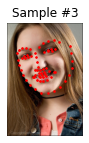

In [5]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

## Transforms 变换

从上面可以看到的一个问题是样本的大小不同。 大多数神经网络期望图像的大小固定。 因此，我们将需要编写一些预处理代码。 让我们创建三个转换：

- `Rescale`：缩放图像
- `RandomCrop`：从图像中随机裁剪。 这是数据增强。
- `ToTensor`：将 numpy 图像转换为 torch 图像（我们需要交换轴）。

我们会将它们编写为可调用的类，而不是简单的函数，这样就不必每次调用转换时都传递其参数。 为此，我们只需要实现`__call__`方法，如果需要，还可以实现`__init__`方法。 然后我们可以使用这样的变换：

In [6]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

### 撰写变换

现在，我们将转换应用于样本。

假设我们要将图片的较短边重新缩放为 256，然后从中随机裁剪一个尺寸为 224 的正方形。 也就是说，我们要组成`Rescale`和`RandomCrop`转换。 `torchvision.transforms.Compose`是一个简单的可调用类，它使我们可以执行此操作。

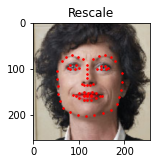

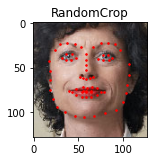

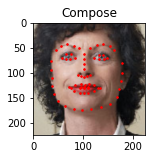

In [7]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

## 遍历数据集

让我们将所有这些放在一起，以创建具有组合转换的数据集。 总而言之，每次采样此数据集时：

- 从文件中即时读取图像
- 转换应用于读取的图像
- 由于其中一种转换是随机的，因此数据是在采样时进行增强

我们可以像以前一样使用`for i in range`循环遍历创建的数据集。

In [8]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


但是，通过使用简单的`for`循环迭代数据，我们失去了很多功能。 特别是，我们错过了：

- 批量处理数据
- 打乱数据
- 使用`multiprocessing`工作程序并行加载数据。

`torch.utils.data.DataLoader`是提供所有这些功能的迭代器。 下面使用的参数应该清楚。 感兴趣的一个参数是`collate_fn`。 您可以使用`collate_fn`指定需要如何精确地分批样品。 但是，默认精度在大多数情况下都可以正常工作。

In [9]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=0)
print(dataloader)
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')



0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


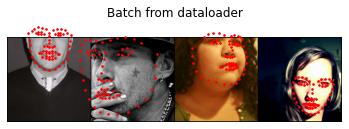

In [10]:
if __name__ == '__main__':
    for i_batch, sample_batched in enumerate(dataloader):
        print(i_batch, sample_batched['image'].size(), sample_batched['landmarks'].size())
        # observe 4th batch and stop.
        if i_batch == 3:
            plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## 后记：torchvision

在本教程中，我们已经看到了如何编写和使用数据集，转换和数据加载器。 `torchvision`包提供了一些常见的数据集和转换。 您甚至不必编写自定义类。 Torchvision 中可用的更通用的数据集之一是`ImageFolder`。 假定图像的组织方式如下：

```
root/ants/xxx.png
root/ants/xxy.jpeg
root/ants/xxz.png
.
.
.
root/bees/123.jpg
root/bees/nsdf3.png
root/bees/asd932_.png
```

其中“蚂蚁”，“蜜蜂”等是类别标签。 同样也可以使用对`PIL.Image`，`Scale`等`PIL.Image`进行操作的通用转换。 您可以使用以下代码编写数据加载器，如下所示

In [19]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'hymenoptera_data/train'

有关训练代码的示例，请参见[计算机视觉转换学习教程](https://pytorch.apachecn.org/docs/1.4/transfer_learning_tutorial.html)。

**脚本的总运行时间：**(0 分钟 58.611 秒）

[`Download Python source code: data_loading_tutorial.py`](https://pytorch.apachecn.org/docs/_downloads/0daab3cdf9be9579bd736e92d8de3917/data_loading_tutorial.py) [`Download Jupyter notebook: data_loading_tutorial.ipynb`](https://pytorch.apachecn.org/docs/_downloads/21adbaecd47a412f8143afb1c48f05a6/data_loading_tutorial.ipynb)

[由狮身人面像画廊](https://sphinx-gallery.readthedocs.io/)生成的画廊